**Import the required libraries**

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.cluster import SpectralClustering
import hdbscan
import umap
from umap import UMAP
import io
import sys
from Pipeline import DPA
from Pipeline import PAk
from Pipeline import twoNN
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from sklearn.linear_model import LinearRegression as LR
from sklearn.neighbors import NearestNeighbors
%load_ext autoreload
%autoreload 2

/home/gabriel/miniconda3/envs/venvdpa/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Load Data**

In [3]:
'''import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
import pandas as pd

# Activate the pandas conversion
pandas2ri.activate()

# Read the RDS file
readRDS = robjects.r['readRDS']
data = readRDS('/home/gabriel/Documents/UNSUPERVISED_LEARNING/Final_project/b53b3bcd-3485-4562-a543-e473dfef3b27')'''



"import rpy2.robjects as robjects\nfrom rpy2.robjects import pandas2ri\nimport pandas as pd\n\n# Activate the pandas conversion\npandas2ri.activate()\n\n# Read the RDS file\nreadRDS = robjects.r['readRDS']\ndata = readRDS('/home/gabriel/Documents/UNSUPERVISED_LEARNING/Final_project/b53b3bcd-3485-4562-a543-e473dfef3b27')"

In [4]:
data =np.load('/home/gabriel/Documents/Numerical Analysis/Final_project/mnist.npz') #loading the data

In [5]:
#Split the data between train and test sets
x_train = data['arr_0']
y_train = data['arr_1']
x_test  = data['arr_2']
y_test  = data['arr_3']

#Chech the size of the train/test sets
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [6]:
# Flatten the images and normalize pixel values
X_train_flattened = x_train.reshape((x_train.shape[0], -1)) / 255.0
X_test_flattened = x_test.reshape((x_test.shape[0], -1)) / 255.0

# Standardize the training dataset
data_normalized = (X_train_flattened - X_train_flattened.mean(axis=0))

In [7]:
labels= y_train

In [8]:
# Transform labels in one-dimensional array making it easier to use in calculations 
# and comparisons with predicted labels.
ground_truth_labels = labels


In [8]:
ground_truth_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

## 20264 GENES

### Intrinsic dimension calculation

In [52]:
from Pipeline import twoNN

d_est = twoNN.twoNearestNeighbors()

In [53]:
dim = d_est.fit(data_normalized).dim_
dim

15

In [54]:
def two_NN(data, choice: str, discard_fraction = 0.1):
    """
    Given a dataset, returns the intrinsic dimension using 2-nn method.
    Input:
    - data: dataset
    - choice: how to compute the intrinsic dimensionality. {'ML', 'CDF'}
    """
    neigh = NearestNeighbors(n_neighbors=2).fit(data)
    distances, _ = neigh.kneighbors(return_distance=True)
    distances = distances[(distances > 1.e-5)[:,0],:]
    mu = distances[:,1]/distances[:,0]

    if choice == 'ML':
        return data.shape[0]/np.sum(np.log(mu))
    
    if choice == 'CDF':
        cdf = np.arange(mu.shape[0])/mu.shape[0]
        mu = mu[np.argsort(mu)]
        lr = LR(fit_intercept = False)
        lr.fit(np.log(mu).reshape(-1, 1), -np.log(1-cdf).reshape(-1, 1))
        d= lr.coef_[0][0]
        return d

In [55]:
'''avg_ID_ML = two_NN(data_normalized,'ML')
print("Average Intrinsic Dimension with ML:", avg_ID_ML)'''

'avg_ID_ML = two_NN(data_normalized,\'ML\')\nprint("Average Intrinsic Dimension with ML:", avg_ID_ML)'

In [56]:
'''avg_ID_CDF = two_NN(data_normalized,'CDF')
print("Average Intrinsic Dimension with ML:", avg_ID_CDF)'''

'avg_ID_CDF = two_NN(data_normalized,\'CDF\')\nprint("Average Intrinsic Dimension with ML:", avg_ID_CDF)'

### **Dimensionality reduction of the data to visualize and get an intuitive understanding of potential clusters**

#### **2D**

In [9]:
# Apply UMAP
start=time.time()
umap = UMAP(n_components=2, random_state=42)
data_umap = umap.fit_transform(data_normalized)
end=time.time()
print(end-start)


103.65261554718018


In [22]:
# Visualization
plt.figure(figsize=(6, 5))
sns.scatterplot(x=data_umap[:, 0], y=data_umap[:, 1], hue=labels, palette="Paired", s=60, alpha=0.8)
plt.title("UMAP projection of Gene Expression Data with Ground Truth Labels", fontsize=16)
plt.xlabel("UMAP-1", fontsize=14)
plt.ylabel("UMAP-2", fontsize=14)
plt.legend(title='Cancer Type')
plt.grid(True)
plt.show()

#### **3D**

In [9]:
# Apply UMAP
start=time.time()
umap = UMAP(n_components=3, random_state=42)
data_umap_3d = umap.fit_transform(data_normalized)
end=time.time()
print(end-start)

91.40897536277771


In [10]:

# Encode the labels to integers for color mapping
label_encoder = LabelEncoder()
ground_truth_labels_encoded = label_encoder.fit_transform(ground_truth_labels)

# Plotting the 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(data_umap_3d[:, 0], data_umap_3d[:, 1], data_umap_3d[:, 2], 
                     c=ground_truth_labels_encoded, cmap='Paired', s=20, alpha=0.8)


ax.set_title("UMAP 3D projection of Gene Expression Data with Ground Truth Labels", fontsize=16)
ax.set_xlabel("UMAP-1", fontsize=14)
ax.set_ylabel("UMAP-2", fontsize=14)
ax.set_zlabel("UMAP-3", fontsize=14)

# Legend with label names
handles, _ = scatter.legend_elements()
legend_labels = label_encoder.inverse_transform(np.arange(len(handles)))
legend = ax.legend(handles, legend_labels, title="Cancer Type")
ax.add_artist(legend)

plt.show()

In [11]:
from sklearn.preprocessing import LabelEncoder
import plotly.express as px

# Extract ground truth labels
ground_truth_labels = labels

# Encode the labels to integers for color mapping
label_encoder = LabelEncoder()
ground_truth_labels_encoded = label_encoder.fit_transform(ground_truth_labels)

# Create a DataFrame for Plotly
plot_data = pd.DataFrame(data_umap_3d, columns=['UMAP-1', 'UMAP-2', 'UMAP-3'])
plot_data['Cancer Type'] = ground_truth_labels

# Plotting the 3D scatter plot with Plotly
fig = px.scatter_3d(plot_data, x='UMAP-1', y='UMAP-2', z='UMAP-3', color='Cancer Type',
                    title="UMAP 3D projection of Gene Expression Data with Ground Truth Labels",
                    labels={'Cancer Type': 'Cancer Type'}, opacity=0.7)
fig.update_traces(marker=dict(size=5))
fig.show()


#### Since UMAP preserves the original structure of the data better than other methods and the "natural clusters" seems to be well defined I decided to try a flat clustering algorithm as K-means.

### K-means

In [14]:
# Range of k values to evaluate
k_values = range(1, 21)
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_normalized)
    inertia_values.append(kmeans.inertia_)




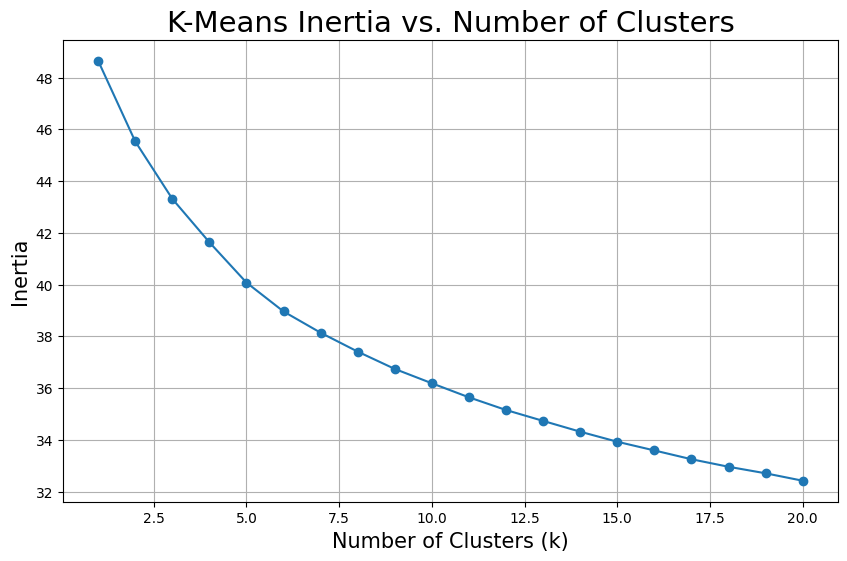

In [15]:
# Plotting the loss (inertia) vs. the number of clusters (k)
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)', fontsize=15)
plt.ylabel('Inertia', fontsize=15)
plt.title('K-Means Inertia vs. Number of Clusters', fontsize=21)
plt.grid(True)
plt.show()

#### we can a subtle ELBO for k=5 which agree with the "natural clusters" observed in the UMAP dimensionality reduction


In [24]:
kmeans = KMeans(n_clusters=10, random_state=42)  
kmeans_labels = kmeans.fit_predict(data_normalized)

# Evaluate the clustering
ari = adjusted_rand_score(ground_truth_labels, kmeans_labels)
nmi = normalized_mutual_info_score(ground_truth_labels, kmeans_labels)
silhouette = silhouette_score(data_normalized, kmeans_labels)

print(f'Adjusted Rand Index (ARI): {ari}')
print(f'Normalized Mutual Information (NMI): {nmi}')
print(f'Silhouette Score: {silhouette}')


Adjusted Rand Index (ARI): 0.36073100330284136
Normalized Mutual Information (NMI): 0.4904982999497013
Silhouette Score: 0.058500681072473526


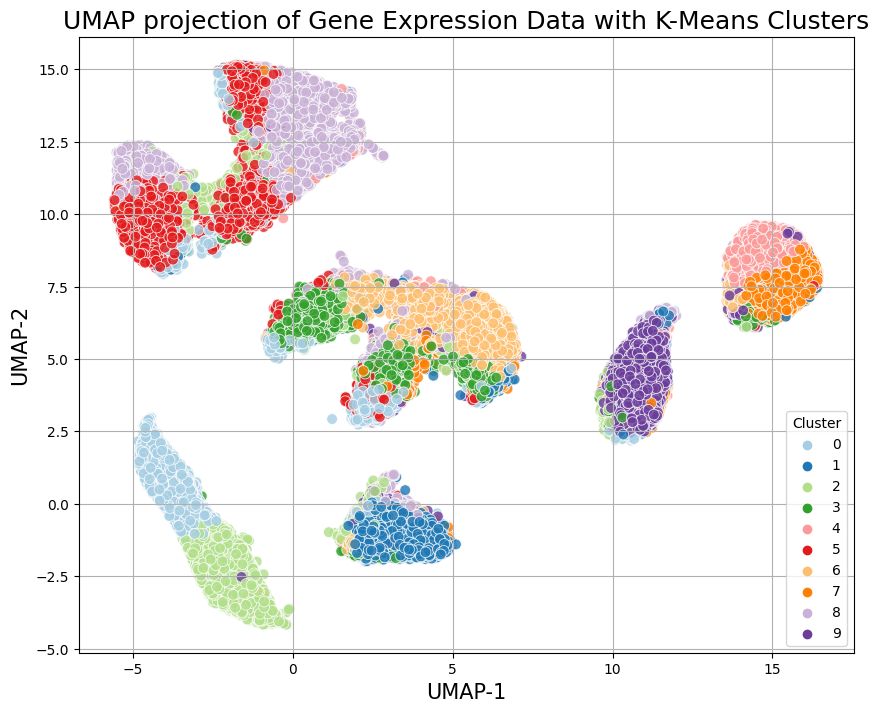

In [25]:
# Plotting
plt.figure(figsize=(10, 8))
sns.scatterplot(x=data_umap[:, 0], y=data_umap[:, 1], hue=kmeans_labels, palette='Paired', s=60, alpha=0.8)
plt.title("UMAP projection of Gene Expression Data with K-Means Clusters", fontsize=18)
plt.xlabel("UMAP-1", fontsize=15)
plt.ylabel("UMAP-2", fontsize=15)
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

### Desity Peak Advanced (DPA)

### Selection of the best value for Z 

In [7]:
# Define range of Z values to evaluate
Z_values = np.arange(1, 4.5 + 0.5, 0.5)

# Initialize lists to store the results
ari_scores = []
nmi_scores = []
silhouette_scores = []

# Iterate over the range of Z values
for Z in Z_values:
    est = DPA.DensityPeakAdvanced(Z=Z)
    est.fit(data_normalized)
    
    # Get the predicted labels
    dpa_labels = est.labels_
    
    # Compute the evaluation metrics
    ari = adjusted_rand_score(ground_truth_labels, dpa_labels)
    nmi = normalized_mutual_info_score(ground_truth_labels, dpa_labels)
    silhouette = silhouette_score(data_normalized, dpa_labels)
    
    # Store the results
    ari_scores.append(ari)
    nmi_scores.append(nmi)
    silhouette_scores.append(silhouette)
    
    # print(f'Z = {Z}: ARI = {ari}, NMI = {nmi}, Silhouette Score = {silhouette}')

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(Z_values, ari_scores, label='ARI', marker='o')
plt.plot(Z_values, nmi_scores, label='NMI', marker='o')
plt.plot(Z_values, silhouette_scores, label='Silhouette Score', marker='o')
plt.xlabel('Z value')
plt.ylabel('Score')
plt.title('Evaluation Metrics for Different Z Values')
plt.legend()
plt.grid(True)
plt.show()

/home/gabriel/miniconda3/envs/venvdpa/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:390: RuntimeWarning: overflow encountered in scalar multiply
  (tp + fp) * (fp + tn))
/home/gabriel/miniconda3/envs/venvdpa/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:390: RuntimeWarning: overflow encountered in scalar multiply
  (tp + fp) * (fp + tn))
/home/gabriel/miniconda3/envs/venvdpa/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:390: RuntimeWarning: overflow encountered in scalar multiply
  (tp + fp) * (fp + tn))


Althought the best value for z seems to be 2.5, When the sampling is poor, which is likely in high-dimensional spaces as in this case(ID= 38), the density estimation becomes less accurate. To maintain statistical significance under these conditions, the Z value must be lowered.

### **Z= 1.5**

In [32]:
est = DPA.DensityPeakAdvanced(Z=1.5)

In [33]:
start=time.time()
est.fit(data_normalized)
end=time.time()
print(end-start)

827.9109058380127


In [34]:
np.count_nonzero(est.centers_)

89

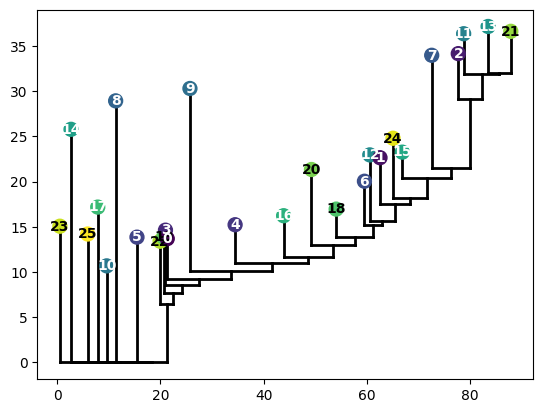

In [29]:
est.get_dendrogram() 

In [ ]:
dpa_labels= est.labels_
# Plotting
fig, ax = plt.subplots(1, 2, figsize=(24, 6))  
# General title
fig.suptitle("20,264 genes", fontsize=25)
# Ground truth plot
sns.scatterplot(x=data_umap[:, 0], y=data_umap[:, 1], hue=ground_truth_labels, palette='Paired', ax=ax[0], s=50)
ax[0].set_title('UMAP with Ground Truth labels', fontsize=20)

# DPA clusters plot
sns.scatterplot(x=data_umap[:, 0], y=data_umap[:, 1], hue=dpa_labels, palette='Paired', ax=ax[1])
ax[1].set_title('DPA Clusters', fontsize=20)

### Selection of the 10000 most informative rows 

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Initialize model
rf = RandomForestClassifier(random_state=42)

# Train model
rf.fit(data_normalized, labels)

# Predict probabilities for each row
probabilities = rf.predict_proba(data_normalized)

# Calculate a score for each row (maximum probability across all classes)
row_scores = np.max(probabilities, axis=1)

# Create a DataFrame to store the row scores
row_scores_df = pd.DataFrame({'row_score': row_scores})

# Rank rows based on their scores
ranked_rows = row_scores_df.sort_values(by='row_score', ascending=False)

# Select top 10000 rows
top_10000_rows = ranked_rows.head(10000).index
data_top_10000_rows = pd.DataFrame(data_normalized).iloc[top_10000_rows]

# Get the labels corresponding to the selected rows
labels_top_10000 = np.array(labels)[top_10000_rows]

# Evaluate the subset with cross-validation
def evaluate_subset(features, labels, model):
    cv_scores = cross_val_score(model, features, labels, cv=5)
    return np.mean(cv_scores)

best_score_rf = evaluate_subset(data_top_10000_rows, labels_top_10000, rf)

print(f'Cross-validated accuracy with Random Forest: {best_score_rf}')

# Now data_best_subset is the selected top 10000 rows
data_best_subset = data_top_10000_rows
labels_best_subset = labels_top_10000


Cross-validated accuracy with Random Forest: 0.9999


In [11]:
labels_best_subset.shape

(10000,)

In [11]:
# Apply UMAP
start=time.time()
umap = UMAP(n_components=2, random_state=42)
data_umap = umap.fit_transform(data_best_subset)
end=time.time()
print(end-start)


29.643214464187622


In [13]:
# Define range of Z values to evaluate
Z_values = np.arange(1, 4.5 + 0.5, 0.5)

# Initialize lists to store the results
ari_scores = []
nmi_scores = []
silhouette_scores = []

# Iterate over the range of Z values
for Z in Z_values:
    est = DPA.DensityPeakAdvanced(Z=Z)
    est.fit(data_best_subset)
    
    # Get the predicted labels
    dpa_labels = est.labels_
    
    # Compute the evaluation metrics
    ari = adjusted_rand_score(labels_best_subset, dpa_labels)
    nmi = normalized_mutual_info_score(labels_best_subset, dpa_labels)
    silhouette = silhouette_score(data_best_subset, dpa_labels)
    
    # Store the results
    ari_scores.append(ari)
    nmi_scores.append(nmi)
    silhouette_scores.append(silhouette)
    
    # print(f'Z = {Z}: ARI = {ari}, NMI = {nmi}, Silhouette Score = {silhouette}')

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(Z_values, ari_scores, label='ARI', marker='o')
plt.plot(Z_values, nmi_scores, label='NMI', marker='o')
plt.plot(Z_values, silhouette_scores, label='Silhouette Score', marker='o')
plt.xlabel('Z value')
plt.ylabel('Score')
plt.title('Evaluation Metrics for Different Z Values')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
est_3 = DPA.DensityPeakAdvanced(Z=2.5)

In [13]:
start=time.time()
est_3.fit(data_best_subset)
end=time.time()
print(end-start)

16.829283237457275


In [14]:
est_3.dim_

14

In [15]:
np.count_nonzero(est_3.centers_)

13

### Selecting the best hyperparameters values for HDBSCAN

In [23]:
# Ranges for min_cluster_size and min_samples
min_cluster_sizes = np.arange(5, 30, 5)
min_samples_list = np.arange(5, 30, 5)

# Initialize lists to store the results
ari_scores = []
nmi_scores = []
silhouette_scores = []

# Iterate over the range of min_cluster_size and min_samples values
for min_cluster_size in min_cluster_sizes:
    for min_samples in min_samples_list:
        # Initialize HDBSCAN with current parameters
        hdbscan_cluster = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
        hdbscan_labels = hdbscan_cluster.fit_predict(data_best_subset)
        
        # Compute the evaluation metrics
        ari = adjusted_rand_score(labels_best_subset, hdbscan_labels)
        nmi = normalized_mutual_info_score(labels_best_subset, hdbscan_labels)
        
        # Check if there is more than one cluster to calculate silhouette score
        if len(np.unique(hdbscan_labels)) > 1:
            silhouette = silhouette_score(data_best_subset, hdbscan_labels)
        else:
            silhouette = np.nan  # Assign NaN if only one cluster
        
        # Store the results
        ari_scores.append((min_cluster_size, min_samples, ari))
        nmi_scores.append((min_cluster_size, min_samples, nmi))
        silhouette_scores.append((min_cluster_size, min_samples, silhouette))
        
        # print(f'min_cluster_size = {min_cluster_size}, min_samples = {min_samples}: ARI = {ari}, NMI = {nmi}, Silhouette Score = {silhouette}')

# Convert results to DataFrame for easier plotting
ari_df = pd.DataFrame(ari_scores, columns=['min_cluster_size', 'min_samples', 'ARI'])
nmi_df = pd.DataFrame(nmi_scores, columns=['min_cluster_size', 'min_samples', 'NMI'])
silhouette_df = pd.DataFrame(silhouette_scores, columns=['min_cluster_size', 'min_samples', 'Silhouette'])





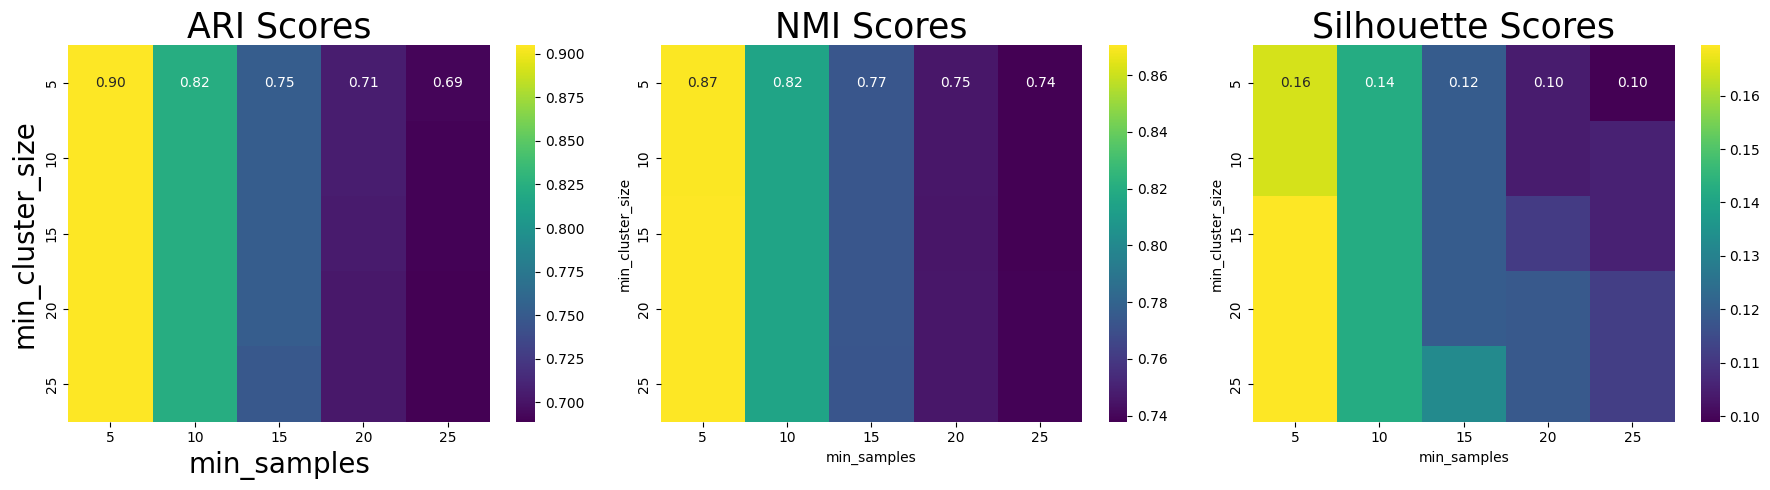

In [24]:
# Plotting the results
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.heatmap(ari_df.pivot(index='min_cluster_size', columns='min_samples', values='ARI'), annot=True, fmt=".2f", cmap="viridis")
plt.title('ARI Scores',fontsize=25)
plt.xlabel('min_samples',fontsize=20)
plt.ylabel('min_cluster_size', fontsize=20)

plt.subplot(1, 3, 2)
sns.heatmap(nmi_df.pivot(index='min_cluster_size', columns='min_samples', values='NMI'), annot=True, fmt=".2f", cmap="viridis")
plt.title('NMI Scores',fontsize=25)

plt.subplot(1, 3, 3)
sns.heatmap(silhouette_df.pivot(index='min_cluster_size', columns='min_samples', values='Silhouette'), annot=True, fmt=".2f", cmap="viridis")
plt.title('Silhouette Scores',fontsize=25)

plt.tight_layout()
plt.show()

### Selecting the best hyperparameters values for Spectral Clustering 

In [28]:
# Define ranges for n_clusters and n_neighbors
n_clusters_list = np.arange(2, 12, 1)  # From 2 to 10 clusters
n_neighbors_list = np.arange(10, 110, 10)  # From 10 to 100 neighbors

# Initialize lists to store the results
ari_scores = []
nmi_scores = []
silhouette_scores = []

# Iterate over the range of n_clusters and n_neighbors values
for n_clusters in n_clusters_list:
    for n_neighbors in n_neighbors_list:
        # Initialize Spectral Clustering with current parameters
        spectral = SpectralClustering(n_clusters=n_clusters, n_neighbors=n_neighbors, affinity='nearest_neighbors')
        spectral_labels = spectral.fit_predict(data_best_subset)
        
        # Compute the evaluation metrics
        ari = adjusted_rand_score(labels_best_subset, spectral_labels)
        nmi = normalized_mutual_info_score(labels_best_subset, spectral_labels)
        
        # Check if there is more than one cluster to calculate silhouette score
        if len(np.unique(spectral_labels)) > 1:
            silhouette = silhouette_score(data_best_subset, spectral_labels)
        else:
            silhouette = np.nan  # Assign NaN if only one cluster
        
        # Store the results
        ari_scores.append((n_clusters, n_neighbors, ari))
        nmi_scores.append((n_clusters, n_neighbors, nmi))
        silhouette_scores.append((n_clusters, n_neighbors, silhouette))
        
        #print(f'n_clusters = {n_clusters}, n_neighbors = {n_neighbors}: ARI = {ari}, NMI = {nmi}, Silhouette Score = {silhouette}')

# Convert results to DataFrame for easier plotting
ari_df = pd.DataFrame(ari_scores, columns=['n_clusters', 'n_neighbors', 'ARI'])
nmi_df = pd.DataFrame(nmi_scores, columns=['n_clusters', 'n_neighbors', 'NMI'])
silhouette_df = pd.DataFrame(silhouette_scores, columns=['n_clusters', 'n_neighbors', 'Silhouette'])




/home/gabriel/miniconda3/envs/venvdpa/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/gabriel/miniconda3/envs/venvdpa/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/gabriel/miniconda3/envs/venvdpa/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/gabriel/miniconda3/envs/venvdpa/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  w

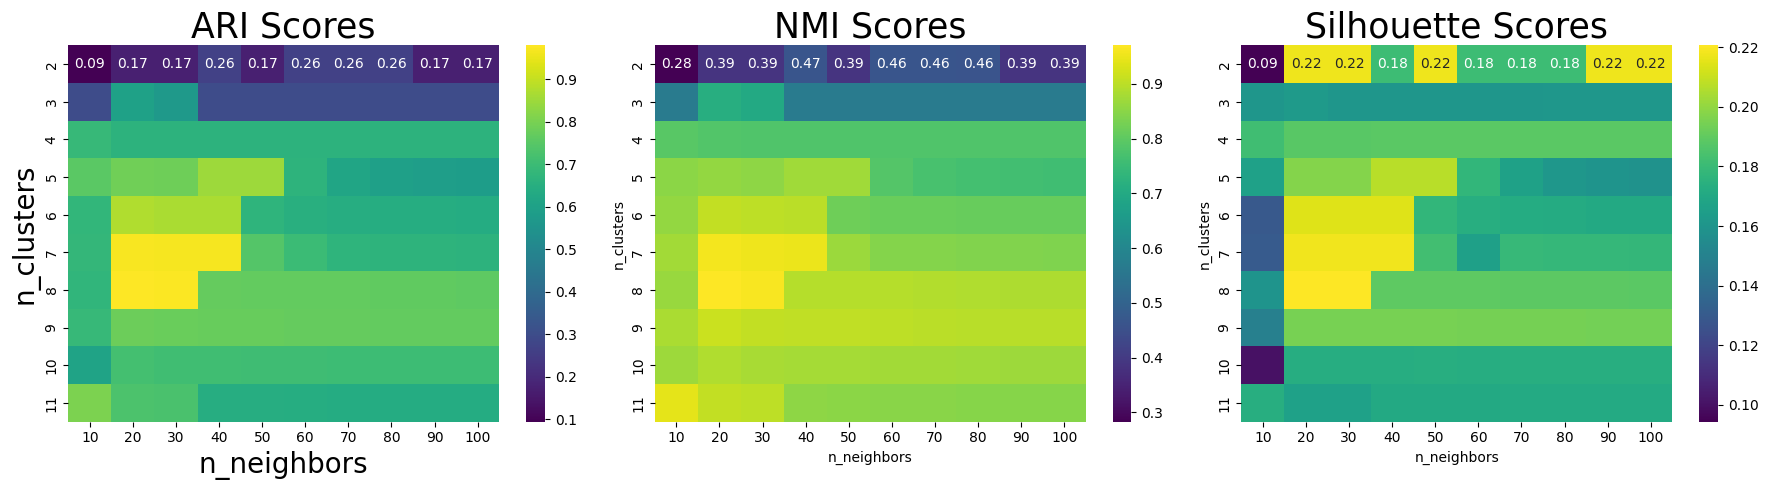

In [29]:
# Plotting the results
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.heatmap(ari_df.pivot(index='n_clusters', columns='n_neighbors', values='ARI'), annot=True, fmt=".2f", cmap="viridis")
plt.title('ARI Scores',fontsize=25)
plt.xlabel('n_neighbors', fontsize=20)
plt.ylabel('n_clusters', fontsize=20)

plt.subplot(1, 3, 2)
sns.heatmap(nmi_df.pivot(index='n_clusters', columns='n_neighbors', values='NMI'), annot=True, fmt=".2f", cmap="viridis")
plt.title('NMI Scores', fontsize=25)
plt.xlabel('n_neighbors')
plt.ylabel('n_clusters')

plt.subplot(1, 3, 3)
sns.heatmap(silhouette_df.pivot(index='n_clusters', columns='n_neighbors', values='Silhouette'), annot=True, fmt=".2f", cmap="viridis")
plt.title('Silhouette Scores', fontsize=25)
plt.xlabel('n_neighbors')
plt.ylabel('n_clusters')

plt.tight_layout()
plt.show()

### Determine the number of clusters using Eigenvalue Gaps.

A significant gap after the kk-th eigenvalue indicates that the data can be well partitioned into kk clusters

In [9]:
import numpy as np
import pandas as pd
from sklearn.neighbors import kneighbors_graph
from scipy.linalg import eigh
import matplotlib.pyplot as plt


# Step 2: Construct the similarity graph using k-nearest neighbors
n_neighbors = 100  # Number of neighbors to use for constructing the graph
knn_graph = kneighbors_graph(data_best_subset, n_neighbors=n_neighbors, mode='connectivity', include_self=True)

# Step 3: Compute the graph Laplacian
W = knn_graph.toarray()
D = np.diag(W.sum(axis=1))
L = D - W

# Step 4: Perform eigenvalue decomposition on the Laplacian
eigenvalues, eigenvectors = eigh(L)

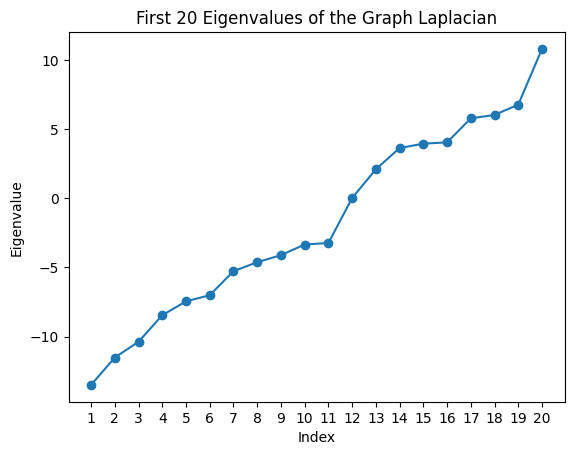

Suggested number of clusters: 19


In [10]:
# Plot only the first 20 eigenvalues
plt.plot(np.arange(1, 21), eigenvalues[:20], marker='o')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('First 20 Eigenvalues of the Graph Laplacian')
plt.xticks(np.arange(1, 21, 1))
plt.show()

# Step 6: Determine the number of clusters by identifying the largest gap
# You can visually inspect the plot to find the largest gap
# Alternatively, you can implement an automated method to find the largest gap
gaps = np.diff(eigenvalues) # calculates the differences between consecutive elements in the eigenvalues array
largest_gap_index = np.argmax(gaps) + 1  # +1 to convert index to the corresponding number of clusters
print(f"Suggested number of clusters: {largest_gap_index}")

### Clusters visualization

In [16]:
dpa_labels= est_3.labels_

In [17]:

hdbscan_cluster = hdbscan.HDBSCAN(min_cluster_size=25, min_samples=5)
hdbscan_labels = hdbscan_cluster.fit_predict(data_best_subset)
spectral = SpectralClustering(n_clusters=8, n_neighbors=20, affinity='nearest_neighbors')
spectral_labels = spectral.fit_predict(data_best_subset)

In [12]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

# Calculate evaluation metrics
ari = adjusted_rand_score(labels_best_subset, hdbscan_labels)
nmi = normalized_mutual_info_score(labels_best_subset, hdbscan_labels)
silhouette = silhouette_score(data_best_subset, hdbscan_labels)

print(f'ARI: {ari}')
print(f'NMI: {nmi}')
print(f'Silhouette Score: {silhouette}')

ARI: 0.9046052704732076
NMI: 0.8705495551786413
Silhouette Score: 0.16941863298416138


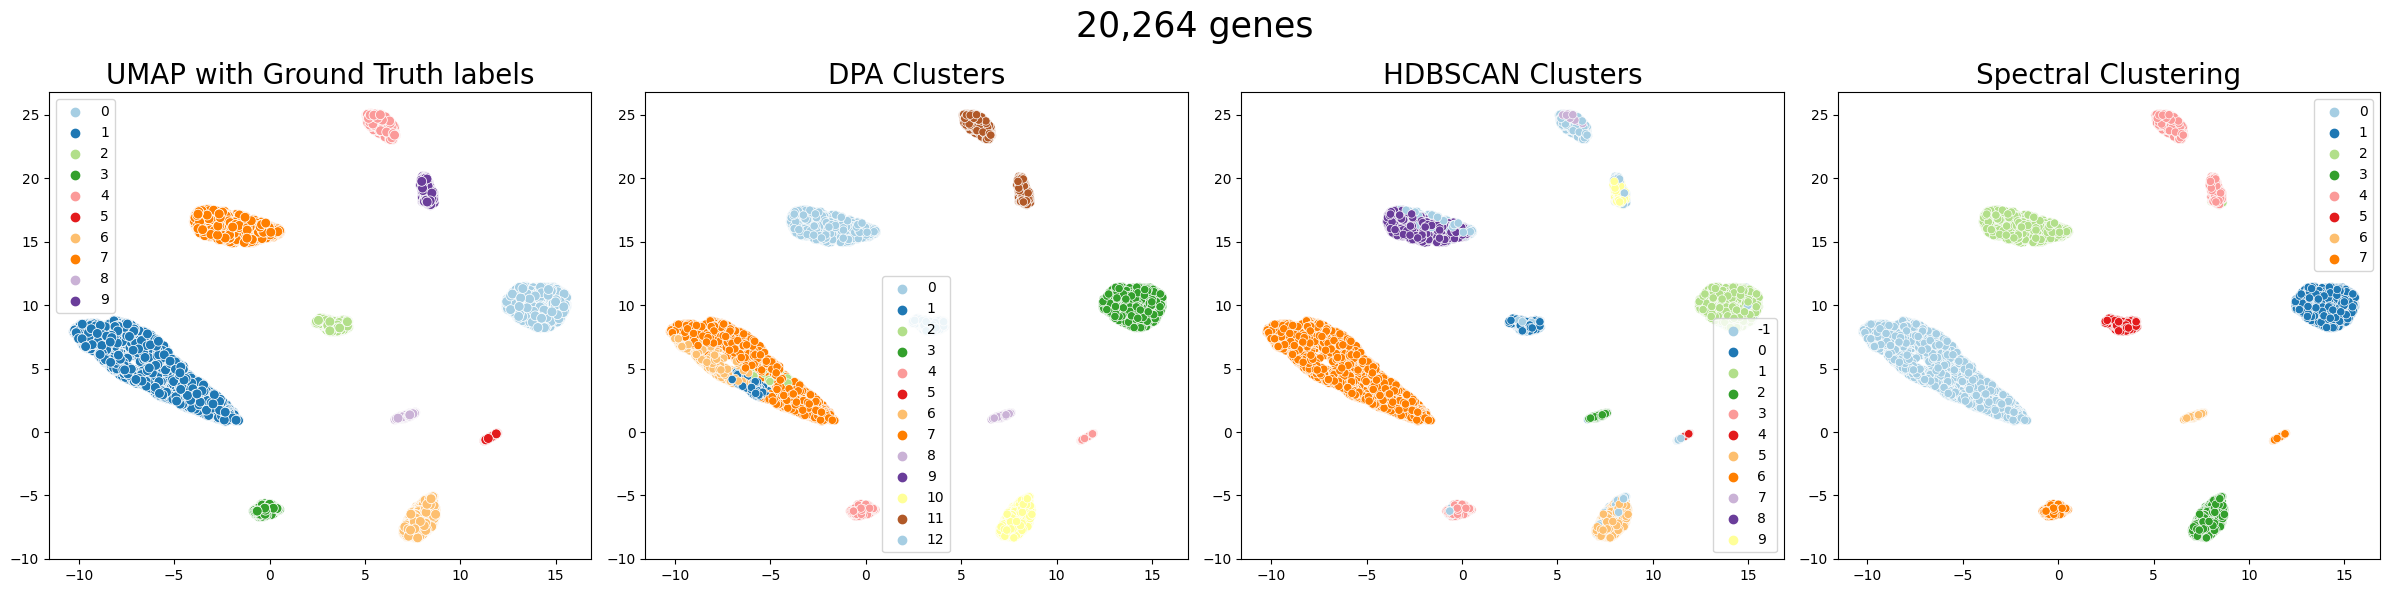

In [19]:
# Plotting
fig, ax = plt.subplots(1, 4, figsize=(24, 6))  
# General title
fig.suptitle("20,264 genes", fontsize=25)
# Ground truth plot
sns.scatterplot(x=data_umap[:, 0], y=data_umap[:, 1], hue=labels_best_subset, palette='Paired', ax=ax[0], s=50)
ax[0].set_title('UMAP with Ground Truth labels', fontsize=20)

# DPA clusters plot
sns.scatterplot(x=data_umap[:, 0], y=data_umap[:, 1], hue=dpa_labels, palette='Paired', ax=ax[1])
ax[1].set_title('DPA Clusters', fontsize=20)

# HDBSCAN clusters plot
sns.scatterplot(x=data_umap[:, 0], y=data_umap[:, 1], hue=hdbscan_labels, palette='Paired', ax=ax[2])
ax[2].set_title('HDBSCAN Clusters', fontsize=20)

# Spectral clustering plot
sns.scatterplot(x=data_umap[:, 0], y=data_umap[:, 1], hue=spectral_labels, palette='Paired', ax=ax[3])
ax[3].set_title('Spectral Clustering', fontsize=20)

plt.tight_layout()
plt.show()


In [20]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

# Calculate evaluation metrics
ari = adjusted_rand_score(labels_best_subset, dpa_labels)
nmi = normalized_mutual_info_score(labels_best_subset, dpa_labels)
silhouette = silhouette_score(data_best_subset, dpa_labels)

print(f'ARI: {ari}')
print(f'NMI: {nmi}')
print(f'Silhouette Score: {silhouette}')

ARI: 0.814434183784664
NMI: 0.9076970360552847
Silhouette Score: 0.02502421662211418


In [21]:
dpa_labels_halos= est_3.halos_

In [24]:
# Calculate evaluation metrics
ari = adjusted_rand_score(labels_best_subset, dpa_labels_halos)
nmi = normalized_mutual_info_score(labels_best_subset, dpa_labels_halos)
silhouette = silhouette_score(data_best_subset, dpa_labels_halos)

print(f'ARI_Halo: {ari}')
print(f'NMI_Halo: {nmi}')
print(f'Silhouette Score_Halo: {silhouette}')

ARI_Halo: 0.581303075557607
NMI_Halo: 0.7702077659511837
Silhouette Score_Halo: -0.10304009914398193


In [25]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

# Calculate evaluation metrics
ari = adjusted_rand_score(labels_best_subset, spectral_labels)
nmi = normalized_mutual_info_score(labels_best_subset, spectral_labels)
silhouette = silhouette_score(data_best_subset, spectral_labels)

print(f'ARI: {ari}')
print(f'NMI: {nmi}')
print(f'Silhouette Score: {silhouette}')

ARI: 0.9799428867488683
NMI: 0.9704553957080412
Silhouette Score: 0.22026264667510986
